In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
print('The variables present in the data are:')
for x in list(train):
    print(x, end=' ')

The variables present in the data are:
PassengerId Survived Pclass Name Sex Age SibSp Parch Ticket Fare Cabin Embarked 

The variables 'PassengerId', 'Name', 'Ticket', and 'Embarked' are not expected to have an influence on the survival of a passenger. So we will drop these variables in order to simplify our analysis.

In [3]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1, inplace=True)
train.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
count,891.000000,891.000000,891,714.000000,891.000000,891.000000,891.000000,204
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,147
top,NaN,NaN,male,NaN,NaN,NaN,NaN,C23 C25 C27
freq,NaN,NaN,577,NaN,NaN,NaN,NaN,4
mean,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN


Let us now check for missing values.

In [4]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
dtype: int64

Majority of the values for the variable 'Cabin' are missing, and certain values for the variable 'Age' are also missing. Since cabin number is a non-numerical data, filling the null values with a single value makes little sense. To avoid unnecessary complicacy, we will drop the 'Cabin' variable despite it carrying certain relevance in our study.

We can observe that the variable 'Age' is highly significant for our study, so we will fill the null values with the average age value.

In [5]:
train.fillna(value={'Age': train['Age'].mean()}, inplace=True)
train.dropna(axis=1, inplace=True)

Now, we normalize the data stored in the 'Age' and 'Fare' columns, so tat gradient descent can work in a better way.

In [6]:
train['Age'] = train['Age'] / (train['Age'].max() - train['Age'].min())
train['Fare'] = train['Fare'] / (train['Fare'].max() - train['Fare'].min())
train.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,577,NaN,NaN,NaN,NaN
mean,0.383838,2.308642,NaN,0.373198,0.523008,0.381594,0.062858
std,0.486592,0.836071,NaN,0.163383,1.102743,0.806057,0.096995
min,0.000000,1.000000,NaN,0.005278,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.276451,0.000000,0.000000,0.015440
50%,0.000000,3.000000,NaN,0.373198,0.000000,0.000000,0.028213
75%,1.000000,3.000000,NaN,0.439809,1.000000,0.000000,0.060508


In [7]:
X_train = np.zeros((train.shape[0], 9))
Y_train = np.zeros((train.shape[0], 1))

for i, x in train.iterrows():
    X_train[i, x['Pclass'] - 1] = 1
    if x['Sex'] == 'M':
        X_train[i, 3] = 1
    else:
        X_train[i, 4] = 1
    X_train[i, 5:] = x['Age'], x['SibSp'], x['Parch'], x['Fare']
    Y_train[i] = x['Survived']

We will now define some basic functions that will help us in realizing the various steps of logistic regression. These functions are called by the function <code>logistic_regression()</code>.

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def initialize(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

In [10]:
def propagate(w, b, X, Y):
    m = X.shape[0]
    A = sigmoid(np.dot(X, w) + b)
    J = (-1 / m) * (np.dot(Y.T, np.log(A)) + np.dot(1 - Y.T, np.log(1- A)))
    
    dw = (1 / m) * np.dot(X.T, A - Y)
    db = (1 / m) * np.sum(A - Y, axis=0)
    
    grads = {
        'dw': dw,
        'db': db
    }
    
    return grads, np.squeeze(J)

In [11]:
def optimize(w, b, X, Y, iterations, alpha, print_costs=False):
    costs = []
    for i in range(iterations):
        grads, cost = propagate(w, b, X, Y)
        costs.append(cost)
        if print_costs and (i + 1) % 100 == 0:
            print('Cost after ', i + 1, ' iterations:', cost)
        w -= alpha * grads['dw']
        b -= alpha * grads['db']
    
    params = {
        'w': w,
        'b': b
    }
    
    return params, grads, costs

In [12]:
def predict(w, b, X):
    m = X.shape[0]
    A = sigmoid(np.dot(X, w) + b)
    Y_prediction = np.zeros((m, 1))
    
    for i in range(m):
        if A[i] >= 0.5:
            Y_prediction[i] = 1
    
    return Y_prediction

In [13]:
def logistic_regression(X_train, Y_train, X, iterations, alpha, print_costs=False):
    n_train = X_train.shape[1]
    w, b = initialize(n_train)
    params, grads, costs = optimize(w, b, X_train, Y_train, iterations, alpha, print_costs)
    
    w = params['w']
    b = params['b']
    
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction = predict(w, b, X)
    
    train_accuracy = 100 - np.mean(np.abs(Y_train - Y_prediction_train), axis=0) * 100
    print('Training accuracy:', train_accuracy)
    
    model = {
        'Y_prediction_train': Y_prediction_train,
        'Y_prediction': Y_prediction,
        'w': w,
        'b': b,
        'costs': costs
    }
    
    return model

We will now read the test data upon which predictions are to be made.

In [14]:
test = pd.read_csv('test.csv')
test.drop(['Name', 'Ticket', 'Embarked'], axis=1, inplace=True)
test.fillna(value={'Age': train['Age'].mean()}, inplace=True)
test.fillna(value={'Fare': train['Fare'].mean()}, inplace=True)
test.dropna(axis=1, inplace=True)
test['Age'] = test['Age'] / (test['Age'].max() - test['Age'].min())
test['Fare'] = test['Fare'] / (test['Fare'].max() - test['Fare'].min())
test.describe(include='all')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418,418.000000,418.000000,418.000000,418.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN
top,NaN,NaN,male,NaN,NaN,NaN,NaN
freq,NaN,NaN,266,NaN,NaN,NaN,NaN
mean,1100.500000,2.265550,NaN,0.318094,0.447368,0.392344,0.069374
std,120.810458,0.841838,NaN,0.230711,0.896760,0.981429,0.109046
min,892.000000,1.000000,NaN,0.002242,0.000000,0.000000,0.000000
25%,996.250000,1.000000,NaN,0.118687,0.000000,0.000000,0.015412
50%,1100.500000,3.000000,NaN,0.316497,0.000000,0.000000,0.028213
75%,1204.750000,3.000000,NaN,0.471449,1.000000,0.000000,0.061429


In [15]:
X = np.zeros((test.shape[0], 9))

for i, x in test.iterrows():
    X[i, x['Pclass'] - 1] = 1
    if x['Sex'] == 'M':
        X[i, 3] = 1
    else:
        X[i, 4] = 1
    X[i, 5:] = x['Age'], x['SibSp'], x['Parch'], x['Fare']

In [16]:
model = logistic_regression(X_train, Y_train, X, iterations=2000, alpha=0.01, print_costs=True)
test['Survived'] = predict(model['w'], model['b'], X)
test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

Cost after  100  iterations: 0.6600330955777876
Cost after  200  iterations: 0.6464289908561616
Cost after  300  iterations: 0.6380774213148294
Cost after  400  iterations: 0.6317957940035409
Cost after  500  iterations: 0.6267281661138275
Cost after  600  iterations: 0.622541998173641
Cost after  700  iterations: 0.6190487915450468
Cost after  800  iterations: 0.6161156712584914
Cost after  900  iterations: 0.613640514399552
Cost after  1000  iterations: 0.6115422837225427
Cost after  1100  iterations: 0.6097557570173558
Cost after  1200  iterations: 0.6082280005197823
Cost after  1300  iterations: 0.6069157908891656
Cost after  1400  iterations: 0.6057836591368542
Cost after  1500  iterations: 0.6048023775826067
Cost after  1600  iterations: 0.6039477743806553
Cost after  1700  iterations: 0.6031997954126789
Cost after  1800  iterations: 0.6025417558198021
Cost after  1900  iterations: 0.6019597386955119
Cost after  2000  iterations: 0.6014421091478991
Training accuracy: [ 70.2581369

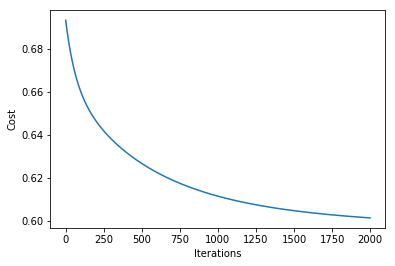

In [17]:
costs = np.squeeze(model['costs'])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.show()

An accuracy of 70% has been achieved on the training data set.